Code based on the actuarial data science tutorial and paper:
https://github.com/actuarial-data-science/Tutorials/tree/master/6%20-%20Lee%20and%20Carter%20go%20Machine%20Learning%20Recurrent%20Neural%20Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

### Data

 The data is divided by genders, and
 the raw mortality rates are denoted by mx, see line 7 of Listing 1. Since we are going to model
 log-mortality rates the raw morality rates need to be strictly positive. In the original data from
 the HMD there were 10 observations with mx = 0, these observations have been replaced
 by a mortality rate average over all available countries in the HMD (of the same age x, in the
 same calendar year t and of the same gender). These modi ed raw mortality rates received a
 flag, indicated on line 6 of Listing 1

In [2]:
mort_data_raw = pd.read_csv("CHE_mort.csv", sep=";")
mort_data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13400 entries, 0 to 13399
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gender        13400 non-null  object 
 1   Year          13400 non-null  int64  
 2   Age           13400 non-null  int64  
 3   Country       13400 non-null  object 
 4   imputed_flag  13400 non-null  bool   
 5   mx            13400 non-null  float64
 6   logmx         13400 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 641.3+ KB


C:\Users\tomasz.skorkowski\AppData\Local\Temp\ipykernel_23956\451866668.py:3: FutureWarning: The provided callable <function mean at 0x000001A813A8EA70> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)
C:\Users\tomasz.skorkowski\AppData\Local\Temp\ipykernel_23956\451866668.py:3: FutureWarning: The provided callable <function mean at 0x000001A813A8EA70> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)


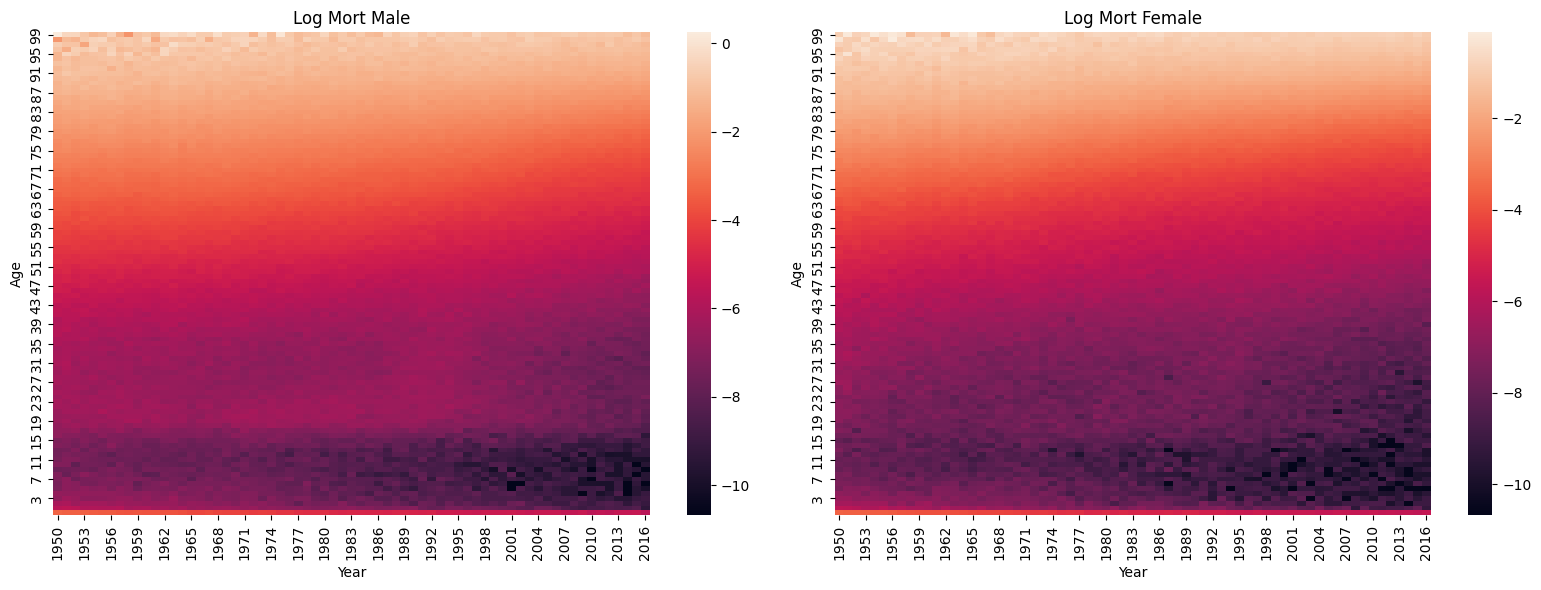

In [3]:
# Function to create heatmap data
def create_heatmap_data(data, gender):
    pivot = data[data["Gender"] == gender].pivot_table(index="Age", columns="Year", values="logmx", aggfunc=np.mean)
    return pivot.sort_index(level='Age', ascending=False)

# Create heatmap data for males and females
heatmap_data = {gender: create_heatmap_data(mort_data_raw, gender) for gender in ['Male', 'Female']}

# Create subplots
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

# Plot heatmaps
for ax, (gender, data) in zip(axs, heatmap_data.items()):
    sns.heatmap(data=data, ax=ax, cbar=True)
    ax.set_title(f"Log Mort {gender}")
    ax.set_xlabel("Year")
    ax.set_ylabel("Age")

plt.tight_layout()
plt.show()

In [4]:
mort_data_raw.describe()

,Year,Age,mx,logmx
count,13400.000000,13400.000000,13400.000000,13400.000000
mean,1983.000000,49.500000,0.055859,-5.211013
std,19.339801,28.867147,0.112893,2.436790
min,1950.000000,0.000000,0.000023,-10.680016
25%,1966.000000,24.750000,0.000737,-7.212923
50%,1983.000000,49.500000,0.003710,-5.596723
75%,2000.000000,74.250000,0.041493,-3.182237
max,2016.000000,99.000000,1.285714,0.251314


In [5]:
# sample mortality rates
data = mort_data_raw.pivot(index=["Gender","Age"], columns="Year", values="logmx")

In [6]:
np.random.seed(42)
sample_size = 5
mort_sample = np.random.choice(data.columns,sample_size)
mort_gender = np.random.choice(["Female","Male"],sample_size)

plot_params = {"year": mort_sample,
               "symbol": ['+', "*", "o", "x", "D"],
               "color": ['C0','C2','C4','C6','C8'],
               "gender": mort_gender}


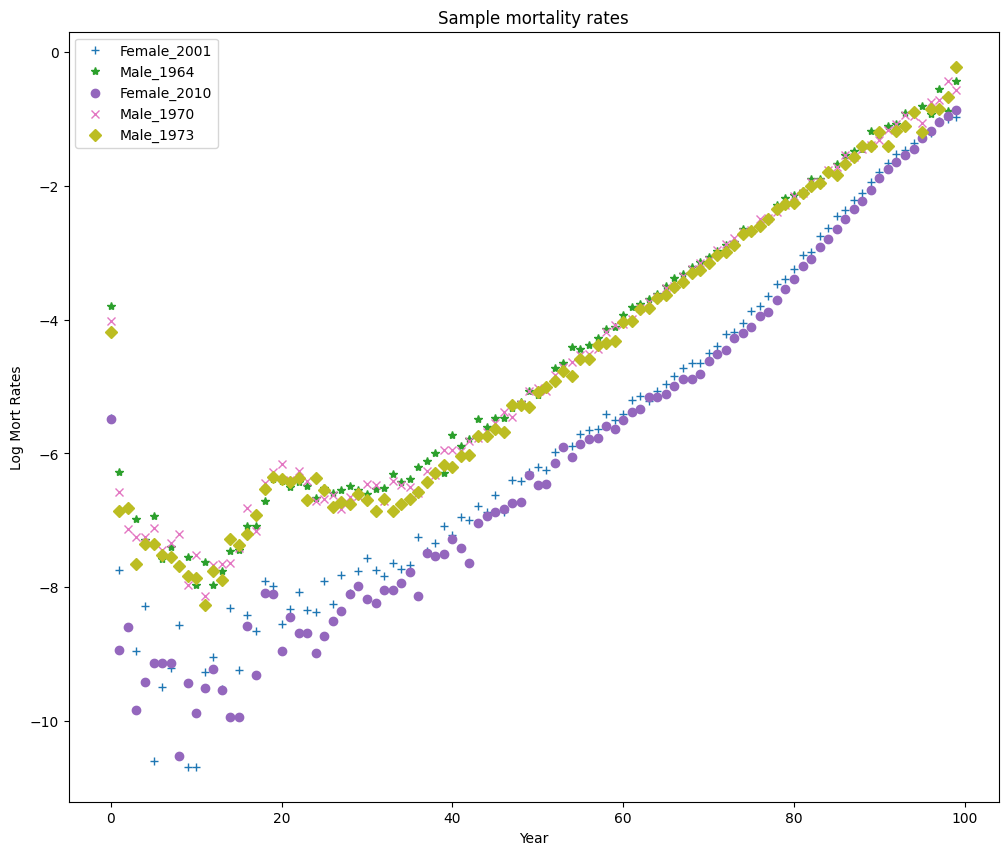

In [7]:
def plot_mort_sample(year, symbol, color, gender):
    fig, ax = plt.subplots(figsize=(12,10))
    # Plot the series
    for i in range(len(year)):
        # Query the pivot table
        selected_series = data.loc[(gender[i], slice(None)), year[i]]
        label = f"{gender[i]}_{year[i]}"
        ax.plot(
            selected_series.index.get_level_values('Age'), 
            selected_series, 
            linestyle='', 
            marker=symbol[i], 
            color=color[i], 
            label=label
        )
    ax.set_title('Sample mortality rates')
    ax.set_xlabel('Year')
    ax.set_ylabel('Log Mort Rates')
    plt.legend( loc='upper left', numpoints = 1 )
    plt.show()
plot_mort_sample(**plot_params)    

#### Smoothing

### Lee-Carter for multi population

### ML models

#### LSTM

In [8]:
from lstm import LstmModel

The modelling approach is as follwos, to predict ln(q_x,t) we use mortality rates from the T previous years and ages in neighberhood of radius tau0//2
Extend the mortality table to by padding. We add at the bottom and at the top the (tau0-1)//2 rows representing the min and max age respectively.

In [9]:
def LSTM_data_prep(tau0: int, T: int, data: pd.DataFrame, gender: str):
    # select gender
    data = data[data["Gender"] == gender]

    # Padding
    age_min, age_max = data["Age"].min(), data["Age"].max()
    year_min, year_max = data["Year"].min(), data["Year"].max()
    concat_data = []
    pad_len = (tau0)//2
    
    data_min_list = [
        data[(data["Age"] == age_min)].assign(Age=age_min - pad - 1)
        for pad in range(pad_len)
    ]
    data_max_list = [
        data[data["Age"] == age_max].assign(Age=age_max + pad + 1)
        for pad in range(pad_len)
    ]
        
    concat_data = pd.concat(data_min_list + [data] + data_max_list, axis=0).reset_index(drop=True)
    pivot_concat_data = concat_data.pivot(index="Age", columns="Year", values="logmx")

    # Generate LSTM sequences
    x_train = np.array(
        [pivot_concat_data.loc[age - pad_len:age + pad_len, year - T:year-1]
        for year in range(year_min + T, year_max+1)
        for age in range(age_min, age_max + 1)
    ])
    Y_train = np.array(
        [pivot_concat_data.loc[age, year]
        for year in range(year_min + T, year_max+1)        
        for age in range(age_min, age_max + 1)
    ])
    
    return Variable(torch.Tensor(x_train).permute(0,2,1)), Variable(torch.Tensor(Y_train).unsqueeze(1))


In [10]:
# Data preprocessing

# Train-Test split
train_cutoff_year = 1999

mort_data_raw_train = mort_data_raw[(mort_data_raw["Year"] <= train_cutoff_year)]
mort_data_raw_test = mort_data_raw[(mort_data_raw["Year"] > train_cutoff_year)]

# Parameters
T = 10 # Look-back period, ie. sequence size from the manual implementation, ie number of LSTM cells
tau0 = 5 # Number of neighbouring ages to smooth future values, odd inetger

# Data preprocessing
x_train, Y_train = LSTM_data_prep(tau0,T,mort_data_raw_train, "Female")

In [62]:
print(
f"""Training data dim: {x_train.size()}
Response data dim: {Y_train.size()}""")

Training data dim: torch.Size([4000, 10, 5])
Response data dim: torch.Size([4000, 1])
      


In [13]:
# Training
epochs = 500
learning_rate = 0.001

input_size = 5
hidden_size = 15
batch_size = 100
criterion = torch.nn.MSELoss()

lstm_models = {f"Lstm{layers}":LstmModel(hidden_sz=hidden_size, input_sz=input_size, num_layers=layers)
                for layers in range(1,4)}
lstm_optimisers = {f"optimizer{layers}":torch.optim.Adam(lstm_models[f"Lstm{layers}"].parameters(), lr=learning_rate)
                for layers in range(1,4)}

In [15]:
model = lstm_models["Lstm3"]
optimizer = lstm_optimisers["optimizer3"]

train_model = 0
if train_model == 1:
    for step in range(epochs):
        outputs = model(x_train)
        optimizer.zero_grad()
    
        loss = criterion(outputs, Y_train)
        loss.backward()

        optimizer.step()
        
        if step % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (step, loss.item()))
    else:
        print("Epoch: %d, loss: %1.5f" % (step, loss.item()))
        torch.save(model.state_dict(), "Lstm3.pth")        
else:
    model = torch.load("Lstm3.pth")
model.eval()

# Crude, hand-made model converges but slowly

Epoch: 0, loss: 35.91248
Epoch: 1, loss: 35.68198
Epoch: 2, loss: 35.45938
Epoch: 3, loss: 35.24414
Epoch: 4, loss: 35.03572
Epoch: 5, loss: 34.83332
Epoch: 6, loss: 34.63591
Epoch: 7, loss: 34.44242
Epoch: 8, loss: 34.25198
Epoch: 9, loss: 34.06391
Epoch: 10, loss: 33.87766
Epoch: 11, loss: 33.69273
Epoch: 12, loss: 33.50861
Epoch: 13, loss: 33.32478
Epoch: 14, loss: 33.14068
Epoch: 15, loss: 32.95572
Epoch: 16, loss: 32.76929
Epoch: 17, loss: 32.58074
Epoch: 18, loss: 32.38943
Epoch: 19, loss: 32.19469
Epoch: 20, loss: 31.99585
Epoch: 21, loss: 31.79228
Epoch: 22, loss: 31.58331
Epoch: 23, loss: 31.36833
Epoch: 24, loss: 31.14672
Epoch: 25, loss: 30.91789
Epoch: 26, loss: 30.68129
Epoch: 27, loss: 30.43639
Epoch: 28, loss: 30.18270
Epoch: 29, loss: 29.91982
Epoch: 30, loss: 29.64739
Epoch: 31, loss: 29.36517
Epoch: 32, loss: 29.07299
Epoch: 33, loss: 28.77085
Epoch: 34, loss: 28.45886
Epoch: 35, loss: 28.13732
Epoch: 36, loss: 27.80668
Epoch: 37, loss: 27.46756
Epoch: 38, loss: 27.12

Lets look at the model prediction on the training set vs actual data

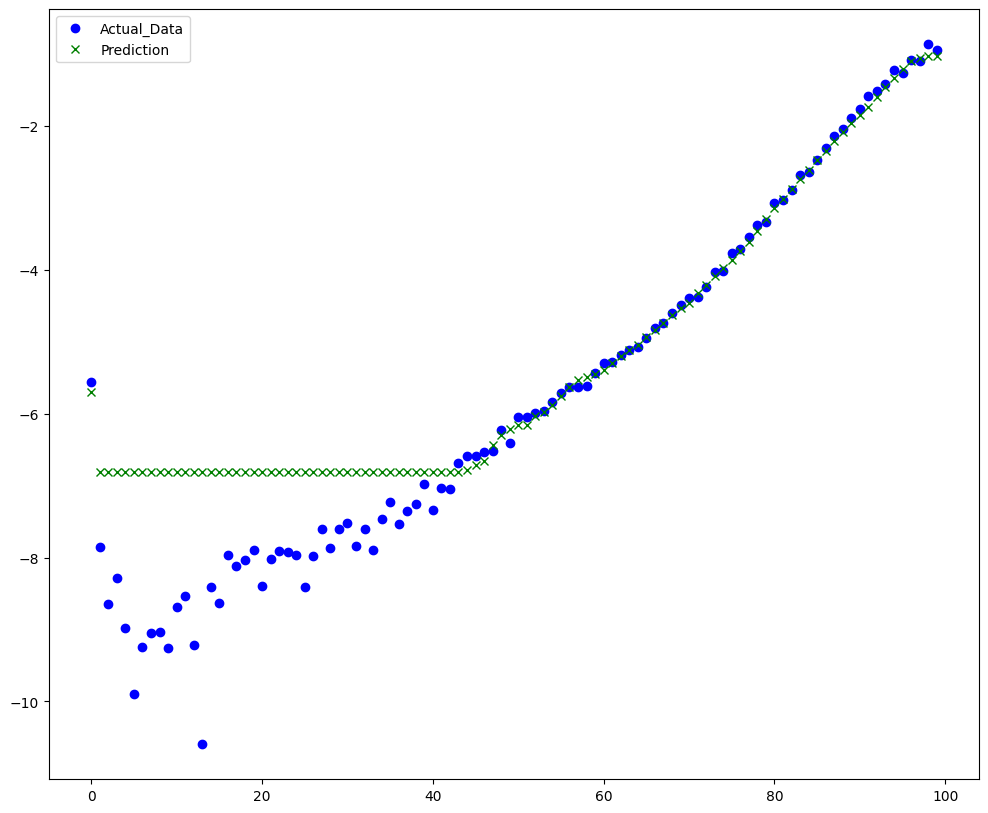

In [63]:
gender = "Female"
year = 1999

x_train_gender_year = x_train[-100::]
mort_data_subset = data.loc[(gender, slice(None)), train_cutoff_year-10:train_cutoff_year]

# Make inference based on the training data

F_1999 = model(x_train_gender_year)
F_199_pred = F_1999.detach().numpy()

# Plot actual data and prediction
_, ax = plt.subplots(figsize=(12,10))
                     
ax.plot(mort_data_subset.index.get_level_values('Age'),
        mort_data_subset[year],
        label='Actual_Data',
        linestyle='', 
        marker="o", 
        color="b"
         )
ax.plot(mort_data_subset.index.get_level_values('Age'),
        F_199_pred,
        label='Prediction',
        linestyle='', 
        marker="x", 
        color="g"
         )
ax.legend()
plt.show()                 


Interestingly the variability for ages below 40 resulted in almost level mortality prediction for ages below that group. To get a better fit below age 40 either more training is required or less historical rates should be used for smoothing. Model has no problem fitting to the ages above age ~40.

In [ ]:
#TODO: Add torch LSTM (potentially Keras as well)
#TODO: Even though the model converges, the overall model accuracy is still far from the numbers reported in the paper - improve

In [ ]:
# TODO: batch learning

In [36]:
np.array(mort_data_raw.iloc[0:2,:])

array([['Female', 1950, 0, 'CHE', False, 0.027293, -3.60112501992636],
       ['Female', 1950, 1, 'CHE', False, 0.003046, -5.79392602450917]],
      dtype=object)

In [46]:
duplicate_groups = mort_data_raw.groupby(['Age', 'Year']).size().reset_index(name='count')
duplicates = duplicate_groups[duplicate_groups['count'] > 1]

print("\nDuplicate groups:")
print(duplicates)


Duplicate groups:
      Age  Year  count
0       0  1950      2
1       0  1951      2
2       0  1952      2
3       0  1953      2
4       0  1954      2
...   ...   ...    ...
6695   99  2012      2
6696   99  2013      2
6697   99  2014      2
6698   99  2015      2
6699   99  2016      2

[6700 rows x 3 columns]


### Transformers